## Image binary classification on DL (MobileNetV2). Face mask detection. Vol.1

### (Diploma project by student @Pawel_MTW "Skillfactory.ru")

###  Перед нами поставлена задача создать модель, которая будет предсказывать наличие маски на лице человека. Это задача  классификации, нужно научить нейросеть делить картинки  на 2 категории: "С маской на лице" и "Без маски". Это задача классификации элементов заданного множества в две группы (предсказание, какой из групп принадлежит каждый элемент множества) на основе правила классификации. 
### Используем бинарную классификацию. 
### Для этого мы используем картинки (предварительно поделенные на 2 категории) для обучения (у нас их более 14 тыс.) и используем глубокое обучение,    Вариант 1: построим сверточную нейросеть CNN и Вариант 2: построим нейросеть на базе предобученной нейросети MobileNetV2 (используя transfer learning). Обучим, сравним показатели, выберем лучший результат.

## Data importing / Загружаем данные
### Установка  импорт библиотек/модулей. 

In [1]:
!pip install --upgrade pip
!pip install cvlib
!pip install opencv-python
!pip install xmltodict
!pip install mtcnn 
!pip install plot-metric
#!pip install face_recognition
!pip install --upgrade imutils

     |████████████████████████████████| 1.5 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1
     |████████████████████████████████| 10.0 MB 9.8 MB/s eta 0:00:01
  Created wheel for cvlib: filename=cvlib-0.2.6-py3-none-any.whl size=10044620 sha256=e34a8b8af0555809ba2dcfdb44b3c4224d0ab5bdb9e4c78e92bbee19da3a12b0
  Stored in directory: /root/.cache/pip/wheels/9b/96/9b/373c07517ffe0bedbebc0813aec1e62cb2bb1dee91b3694895
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=7320b7d2d56820f8469de7abfee87d1428bd16d760fa3d1b519404527fb0e455
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12074 sha256=6a5f7f26fe75957456ee33b7747a66591ad5d23dc001c1700e60f7f2273c99b1
  Stored in directory: /root/.cache/pip/wheel

In [2]:
import cv2
import json
import os
import argparse
import xmltodict
import plot_metric
import pylab as pl
import cvlib as cv
import numpy as np 
import pandas as pd 
import seaborn as sns
import sys, cv2, time
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import scikitplot as skplt
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.utils import plot_model
from scipy.spatial import distance
from keras.models import Sequential
from warnings import filterwarnings
from keras.models import load_model
from tensorflow.keras.layers import *
from matplotlib.patches import Rectangle
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from plot_metric.functions import BinaryClassification
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import SpatialDropout2D, BatchNormalization, Input, Activation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

### Основные настройки

In [3]:
IMG_SIZE = 124 # какого размера подаем изображения в сеть
IMG_CHANNELS = 3   # у RGB 3 канала
input_shape  = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

batch_size = 32 #16 
MIN_DISTANCE = 80 # расстояние между лицами на фото

num_classes = 2
labels=["No Mask","Mask"]
mask_label = {0:"No Mask",1:"Mask"}
color_label = {0:(0,0,255),1:(0,255,0),2:(255,0,0),3:(0,0,0),4:(255,255,255)}
dist_label = {0:(0,255,0),1:(255,0,0)}

DATA_PATH = '../input/'
PATH = "../working/" 
face_model = cv2.CascadeClassifier('../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    pass   # print(dirname)
    #print(os.path.join(dirname, filename))
    
#print(os.listdir(DATA_PATH))

In [4]:
!pip freeze > requirements.txt

In [5]:
!nvidia-smi

Tue Jan 26 06:15:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Будем использовать данные из нескольких датасетов, чтобы данных было много.
### Объединим картинки в группы по предназначению: Train, Test, Validation.

In [6]:
train_dirs = ["/kaggle/input/withwithout-mask/maskdata/maskdata/train",
             "/kaggle/input/withwithout-mask/masks2.0/masks/train",
             "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train",
             "/kaggle/input/faces-with-masks"]

test_dirs = ["/kaggle/input/withwithout-mask/maskdata/maskdata/test",
            "/kaggle/input/withwithout-mask/masks2.0/masks/test",
            "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test",
            "/kaggle/input/face-mask-detection/dataset"]

validation_dirs = ["/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"]

In [7]:
fullimg = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fullimg.append(os.path.join(dirname, filename))

## Preprocessing / Обработка данных

### Используем ImageDataGenerator для аугментации данных:

#### Аугментацию можно провести разными способами,c разными настройками, но помним, что у нас на картинках лица, соответственно есть ряд ограничений (например не переворачивать 180", не искажать слишком сильно).

#### Аугментация вариант №1

In [8]:
train_data_generator = ImageDataGenerator(rescale=1./255, #финальный 
                                          rotation_range=10, #15 
                                          zoom_range=0.15,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          shear_range=0.1, horizontal_flip=True,
                                          fill_mode="nearest")

#train_data_generator = ImageDataGenerator(rescale=1./255, #рабочий
                              #       zoom_range=0.2,
                              #       shear_range=0.2,
                              #       rotation_range=0.2)
            
test_data_generator = ImageDataGenerator(rescale=1./255)

validation_data_generator = ImageDataGenerator(rescale=1./255, #финальный 
                                          rotation_range=10, #15 
                                          zoom_range=0.15,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          shear_range=0.1, horizontal_flip=True,
                                          fill_mode="nearest")

#### Аугментация вариант №2 через albumentations.

In [9]:
#!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [10]:
#from ImageDataAugmentor.image_data_augmentor import *
#import albumentations

In [11]:
# Аугментация вариант №2 через albumentations. 
"""
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=250, width=200),
        albumentations.CenterCrop(height=200, width=250),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(120, 120)
    ])

train_data_generator = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        #validation_split=VAL_SPLIT,
        )

validation_data_generator = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        #validation_split=VAL_SPLIT,
        )

test_data_generator = ImageDataAugmentor(rescale=1./255)
"""

'\nAUGMENTATIONS = albumentations.Compose([\n    albumentations.HorizontalFlip(p=0.5),\n    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),\n    albumentations.OneOf([\n        albumentations.CenterCrop(height=250, width=200),\n        albumentations.CenterCrop(height=200, width=250),\n    ],p=0.5),\n    albumentations.OneOf([\n        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),\n        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)\n    ],p=0.5),\n    albumentations.GaussianBlur(p=0.05),\n    albumentations.HueSaturationValue(p=0.5),\n    albumentations.RGBShift(p=0.5),\n    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),\n    albumentations.Resize(120, 120)\n    ])\n\ntrain_data_generator = ImageDataAugmentor(\n        rescale=1./255,\n        augment = AUGMENTATIONS,\n        #validation_split=VAL_SPLIT,\n        )\n\nvali

## Генерация данных. Завернем наши данные в генератор:

In [12]:
print("Data image Train")
train_generator1 = train_data_generator.flow_from_directory(
        train_dirs[0],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=77,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])
train_generator2 = train_data_generator.flow_from_directory(
        train_dirs[1],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=46,
        interpolation="nearest",
        class_mode='binary',
        classes=["0","1"])
train_generator3 = train_data_generator.flow_from_directory(
        train_dirs[2],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
train_generator4 = train_data_generator.flow_from_directory(
        train_dirs[3],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=163,
        interpolation="nearest",
        class_mode='binary',
        classes=["_","faces_with_mask"])


print("\nData image Test")
test_generator1 = test_data_generator.flow_from_directory(
        test_dirs[0],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=66,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])
test_generator2 = test_data_generator.flow_from_directory(
        test_dirs[1],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=11,
        interpolation="nearest",
        class_mode='binary',
        classes=["0","1"])
test_generator3 = test_data_generator.flow_from_directory(
        test_dirs[2],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=62,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
test_generator4 = test_data_generator.flow_from_directory(
        test_dirs[3],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=55,
        interpolation="nearest",
        class_mode='binary',
        classes=["without_mask","with_mask"])

print("\nData image Validation")
validation_generator1 = validation_data_generator.flow_from_directory(
        validation_dirs[0],
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=80,
        interpolation="nearest",
        class_mode='binary',
        classes=["WithoutMask","WithMask"])
withWithoutMask = {"0":"Without Mask","1":"With Mask"}

Data image Train
Found 616 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 1630 images belonging to 2 classes.

Data image Test
Found 198 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 440 images belonging to 2 classes.

Data image Validation
Found 800 images belonging to 2 classes.


In [13]:
def genToTuple(gen):
    templist = []
    templist2 = []
    for i in range(gen.__len__()):
        tempnext = gen.next()
        templist.append(tempnext[0])
        templist2.append(tempnext[1])
    x=np.concatenate(templist)
    y=np.concatenate(templist2)
    return (x,y)

def combine_tuple(*tuples):
    x=np.concatenate([tuples[i][0] for i in range(len(tuples))])
    y=np.concatenate([tuples[i][1] for i in range(len(tuples))])
    return (x,y.astype(int))   

train_generator1_t = genToTuple(train_generator1)
train_generator2_t = genToTuple(train_generator2)
train_generator3_t = genToTuple(train_generator3)
train_generator4_t = genToTuple(train_generator4)

test_generator1_t = genToTuple(test_generator1)
test_generator2_t = genToTuple(test_generator2)
test_generator3_t = genToTuple(test_generator3)
test_generator4_t = genToTuple(test_generator4)

x_train,y_train = combine_tuple(train_generator1_t,train_generator2_t,train_generator3_t,train_generator4_t)

x_test,y_test = combine_tuple(test_generator1_t,test_generator2_t,test_generator3_t,test_generator4_t)

x_val,y_val = genToTuple(validation_generator1)

In [14]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(12338, 124, 124, 3) (12338,)
(1663, 124, 124, 3) (1663,)
(800, 124, 124, 3) (800,)


### Посмотрим на равномерность распределения картинок по категориям.
#### Распределение в целом равномерное, небольшой перевес  в обучающей выборке в категории "With mask", но поскольку мы будем использовать предобученную сеть MobileNet V2, то это не повлияет на конечный результат.

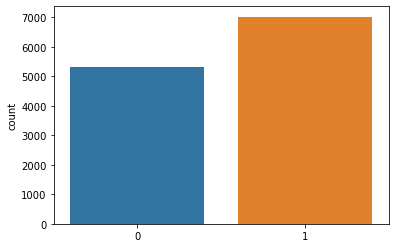

In [15]:
# смотрим распределение картинок по категориям в TRAIN:
sns.countplot(y_train)

In [16]:
# смотрим кол-во картинок по категориям в TRAIN:
category = pd.DataFrame(y_train)  
category.value_counts()

1    7023
0    5315
dtype: int64

In [17]:
# смотрим кол-во картинок по категориям в TRAIN в %:
#category = pd.DataFrame(y_train)  
category.value_counts(normalize=True)


1    0.569217
0    0.430783
dtype: float64

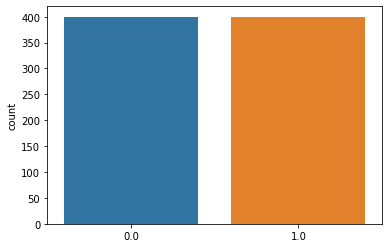

In [18]:
# смотрим распределение картинок по категориям в VALIDATION:
sns.countplot(y_val)

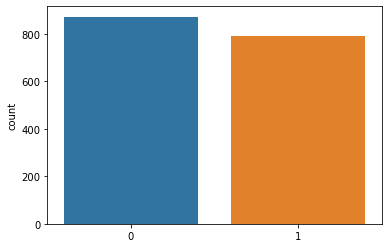

In [19]:
# смотрим распределение картинок по категориям в TEST:
sns.countplot(y_test) 

###  Вглянем на образцы картинок лиц на которых мы будем обучать модель:

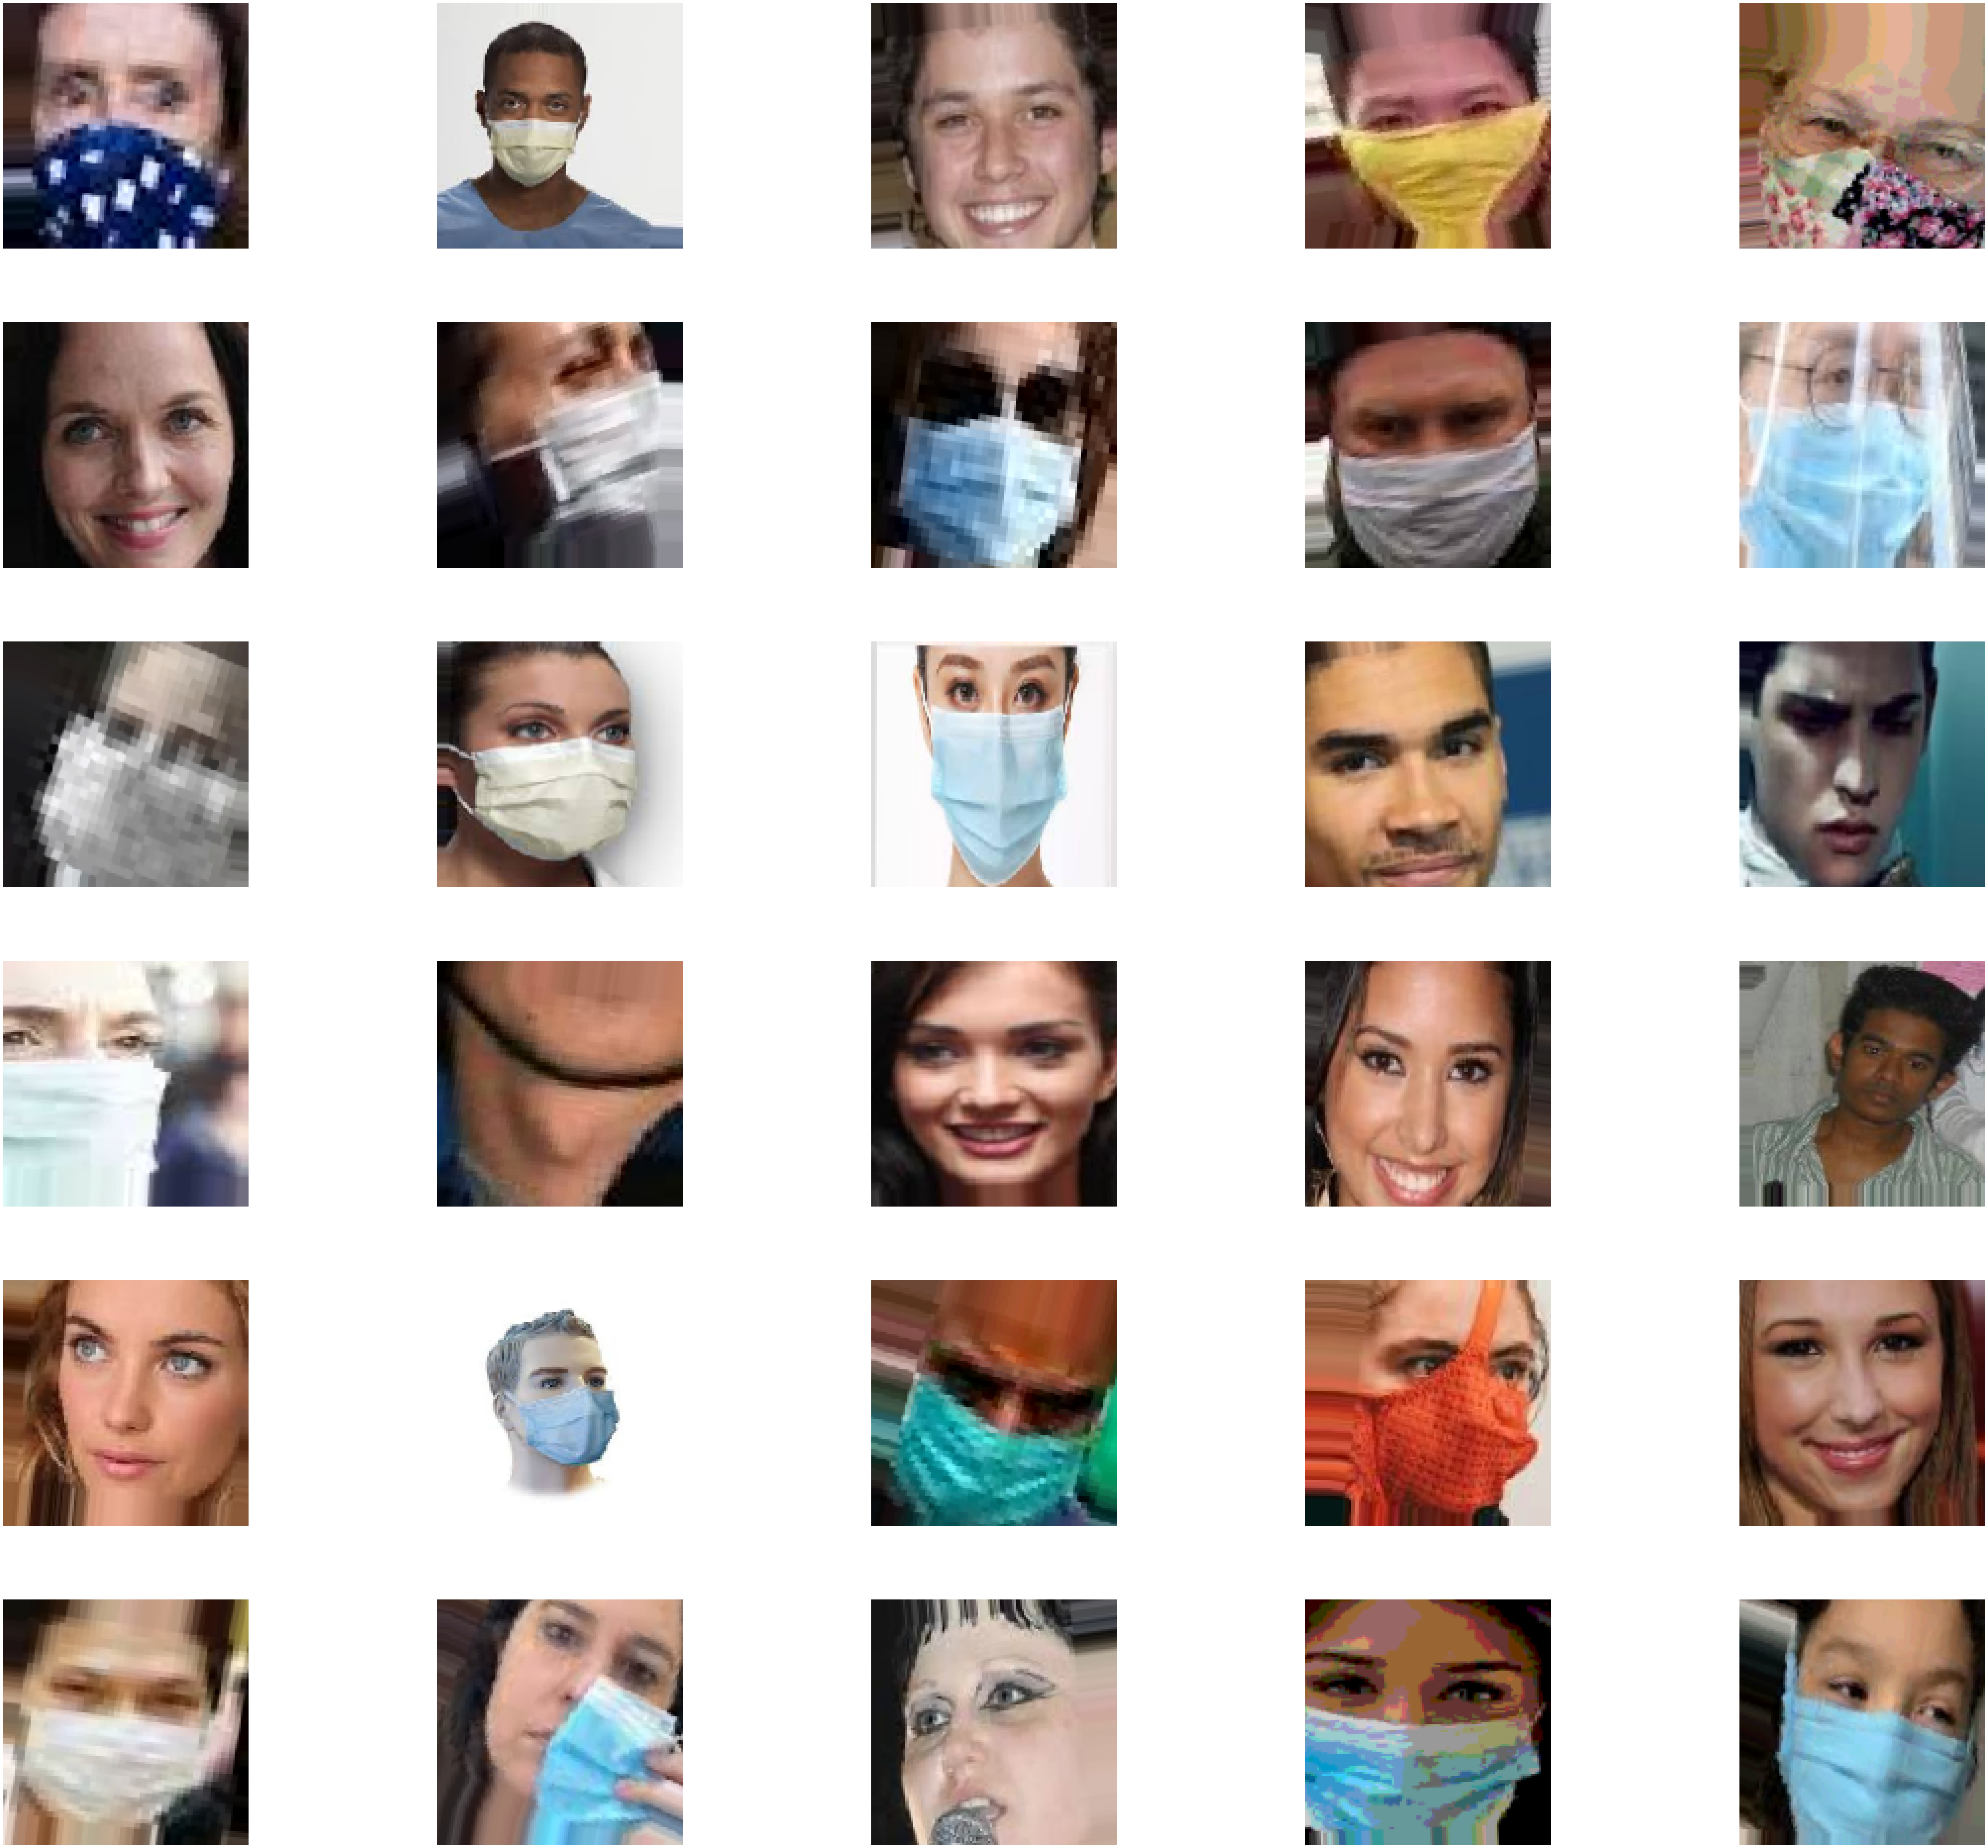

In [20]:
plt.figure(figsize=(100,100))
tempc = np.random.choice(x_train.shape[0],30,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_train.shape[0])
    plt.imshow(x_train[tempc])
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()

## Build Model / Построение модели.

### Вариант #1. Строим сверточную нейронную сеть CNN для классификации лиц по фото по категориям: Результат accuracy: 0.9416, roc_auc: 0.9918

In [21]:
from sklearn.metrics import *

In [22]:
# Вариант 1 построения сети: Результат accuracy_test: 0.9524, roc_auc: 0.9918

def build_model():
        model = Sequential()
        
        model.add(Input(shape=input_shape))

        model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25)) #0.45
        
        model.add(MaxPool2D(pool_size=(4,4)))

        model.add(Conv2D(filters=32,kernel_size=(2,2),padding="same"))
        model.add(Activation("relu"))
        model.add(SpatialDropout2D(0.25)) # 0.45
        
        model.add(MaxPool2D(pool_size=(4,4),strides=(4,4)))
        model.add(Dropout(0.2))        
        model.add(Flatten())
        
        model.add(Dense(256)) # 1024
        model.add(Activation("relu"))
        model.add(Dropout(0.25)) #0.45
        
        model.add(Dense(128)) # 256 1024
        model.add(Activation("relu"))
        model.add(Dropout(0.2)) #0.4
        
        
        model.add(Dense(1))
        model.add(Activation("sigmoid"))
        
        optimizer = Adam ()#(lr=0.001)
        model.compile(optimizer = optimizer ,metrics=["accuracy"], loss = binary_crossentropy) 
        
        return model
    
model1 = build_model() 
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 16)      208       
_________________________________________________________________
activation (Activation)      (None, 124, 124, 16)      0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 32)        2080      
_________________________________________________________________
activation_1 (Activation)    (None, 31, 31, 32)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 31, 31, 32)        0

### Вариант #2 TransferLearning. Построение сети на базе предообученной сети MobileNet V2 (alpha=1.4)

На момент выполнения проекта нейросеть сеть MobileNet V2 (имеется несколько вариаций, мы выбрали Large) все ещё является оптимальным выбором, если брать во внимание размер сети, точность предсказаний и время работы, хотя уже появилась MobileNet V3. 
Итоговый результат обученной модели аccuracy: 0.9861%

### Настраиваем обучение на всех слоях MobileNetV2 (сеть обучается быстро, и так будет точнее результат).

In [23]:
mobilenet = MobileNetV2(alpha=1.4,weights='imagenet',include_top=False,input_shape=(input_shape))
for layer in mobilenet.layers:
    layer.trainable = True #False
model = Sequential()
model.add(mobilenet)
model.add(GlobalMaxPooling2D(),) # GlobalMaxPooling2D или GlobalAveragePooling2D не надо: Flatten())
model.add(Dense(256)) #512
model.add(Activation("relu"))
model.add(Dropout(0.45)) #0.25                   
model.add(Dense(1))
model.add(Activation("sigmoid")) 
model.compile(optimizer="adam",loss=binary_crossentropy, metrics =["accuracy"]) #binary_accuracy accuracy
model.summary()

17833984/17831080 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Functi (None, 4, 4, 1792)        4363712   
_________________________________________________________________
global_max_pooling2d (Global (None, 1792)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               459008    
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
_______________________________________________________

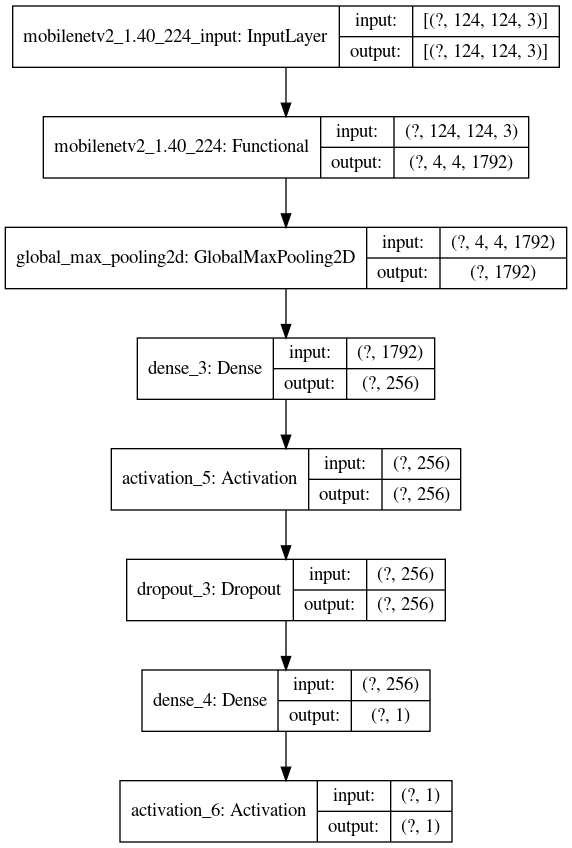

In [24]:
# можно также вывести итоговую схему нейросети в виде красивой картинки: 
plot_model(model,show_shapes=True,show_layer_names=True)

## Train Model / Обучение модели.

### Делаем последние настройки перед обучением модели,  используем ReduceLROnPlateau для гибкого использования LR,а также EarlyStopping для экономии времени и ресурсов обучения.

In [25]:
%%time
#  Используем ReduceLROnPlateau
# ReduceLROnPlateau - уменьшаемый LR: когда результат уже не меняется, LR  уменьшается, и так до min предела указанного:
reducer = ReduceLROnPlateau(monitor='loss',patience=3,factor=0.75,min_lr=0.000000001,verbose=1) #monitor='val_acc' loss
checkpoint = ModelCheckpoint("facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1) #
stopSign = EarlyStopping(monitor = "loss",patience=10,min_delta=0.000000000001,mode="min")
epochs = 100 #120
batch_size = 32 
steps_per_epoch = x_train.shape[0] // batch_size
history = model.fit(x_train, y_train,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 1,
                    batch_size=batch_size,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[stopSign,checkpoint
                               ,reducer
                              ])

Epoch 1/100
385/385 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9769
Epoch 00001: val_accuracy improved from -inf to 0.86250, saving model to facemask.h5
385/385 [==============================] - 28s 72ms/step - loss: 0.1001 - accuracy: 0.9769 - val_loss: 1.8836 - val_accuracy: 0.8625
Epoch 2/100
385/385 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9908
Epoch 00002: val_accuracy improved from 0.86250 to 0.98875, saving model to facemask.h5
385/385 [==============================] - 27s 69ms/step - loss: 0.0326 - accuracy: 0.9908 - val_loss: 0.2496 - val_accuracy: 0.9887
Epoch 3/100
385/385 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9937
Epoch 00003: val_accuracy did not improve from 0.98875
385/385 [==============================] - 26s 68ms/step - loss: 0.0185 - accuracy: 0.9937 - val_loss: 2.6131 - val_accuracy: 0.8963
Epoch 4/100
385/385 [==============================] - ETA: 0s - loss: 0.0357 - ac

Epoch 28/100
385/385 [==============================] - ETA: 0s - loss: 4.8952e-04 - accuracy: 0.9998
Epoch 00028: val_accuracy improved from 0.99625 to 0.99875, saving model to facemask.h5
385/385 [==============================] - 27s 69ms/step - loss: 4.8952e-04 - accuracy: 0.9998 - val_loss: 0.0027 - val_accuracy: 0.9987
Epoch 29/100
385/385 [==============================] - ETA: 0s - loss: 7.4764e-06 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.99875
385/385 [==============================] - 26s 67ms/step - loss: 7.4764e-06 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9975
Epoch 30/100
385/385 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993
Epoch 00030: val_accuracy did not improve from 0.99875
385/385 [==============================] - 26s 68ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.1151 - val_accuracy: 0.9937
Epoch 31/100
385/385 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.

## Training and Validation Visualizations / визуализация процесса обучения

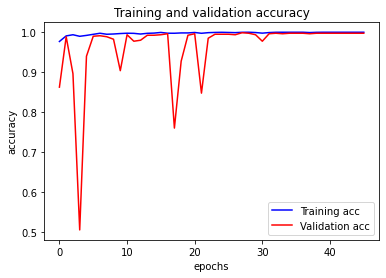

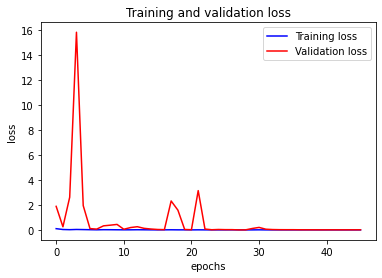

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
 
plt.show()

##  Prediction / Предсказание

### Делаем предсказания на тестовых данных. Выводим матрицу ошибок.

### Результаты получились отличные: крайне небольшое кол-во ложно положительных и малое кол-во ложно отрицательных предсказаний.

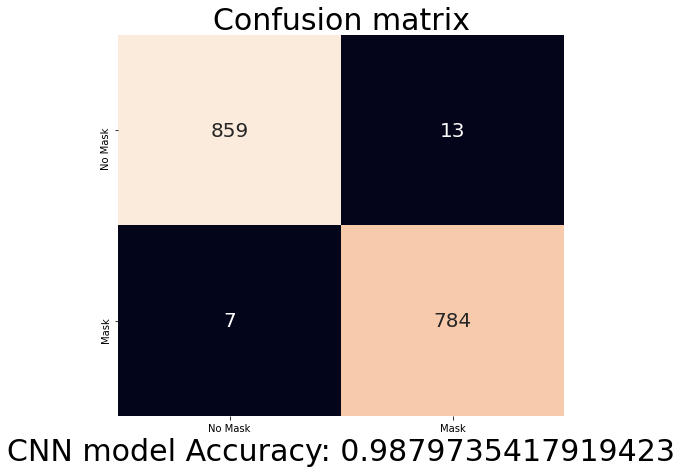

In [27]:
y_pred_classes = model.predict_classes(x_test)
y_pred = model.predict(x_test)

plt.subplots(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test,y_pred_classes),xticklabels=labels,
                                       yticklabels=labels, annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 20})
plt.title("Confusion matrix",fontsize=30)
plt.xlabel(f"CNN model Accuracy: {accuracy_score(y_test,y_pred_classes)}",fontsize=30)
plt.show()

### Printing Classification report/ выводим Classification отчет:

In [28]:
print(classification_report(y_test, y_pred_classes, target_names = labels)) 

              precision    recall  f1-score   support

     No Mask       0.99      0.99      0.99       872
        Mask       0.98      0.99      0.99       791

    accuracy                           0.99      1663
   macro avg       0.99      0.99      0.99      1663
weighted avg       0.99      0.99      0.99      1663



### Вывод: precision и recall показатели очень высокие (почти избегаем ошибок I и II рода).

В нашей проблематике хотелось бы в первую очередь снизить FN (ошибку II рода) - это когда "без маски", но модель говорит что "в маске".

### Отчет по метрикам accuracy  и loss:

In [29]:
# считаем Score модели:
test_loss, test_acc = model.evaluate(x_test, y_test, steps=32)
print('The final test accuracy: ',test_acc)
print('The final test loss: ',test_loss)

32/32 [==============================] - 1s 28ms/step - loss: 0.0977 - accuracy: 0.9880
The final test accuracy:  0.9879735708236694
The final test loss:  0.09774763882160187


### Cчитаем Auc-roс, строим кривую.

### Поскольку мы используем бинарную классификацию, то берем метрики Аuc_roc, Чувствительность и Специфичность для оценки работы сети (tpr - sensivity, fpr - specifity).

In [30]:
y_pred_proba = model.predict_proba(x_test)

In [31]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.9980384254050731

In [32]:
tpr

array([0.        , 0.85461441, 0.87610619, 0.8874842 , 0.89127686,
       0.89380531, 0.89506953, 0.89759798, 0.90139064, 0.90391909,
       0.90771176, 0.91150442, 0.91656131, 0.91782554, 0.92035398,
       0.9216182 , 0.92541087, 0.95828066, 0.9608091 , 0.96839444,
       0.96839444, 0.96965866, 0.96965866, 0.97345133, 0.97345133,
       0.97724399, 0.97724399, 0.98103666, 0.98103666, 0.98230088,
       0.98482933, 0.98735777, 0.98735777, 0.988622  , 0.988622  ,
       0.99494311, 0.99494311, 0.99620733, 0.99620733, 0.99747155,
       0.99747155, 0.99873578, 0.99873578, 1.        , 1.        ,
       1.        ])

In [33]:
fpr

array([0.        , 0.00229358, 0.00344037, 0.00458716, 0.00458716,
       0.00458716, 0.00458716, 0.00458716, 0.00458716, 0.00458716,
       0.00458716, 0.00458716, 0.00458716, 0.00458716, 0.00458716,
       0.00458716, 0.00458716, 0.00458716, 0.00458716, 0.00458716,
       0.00573394, 0.00573394, 0.00688073, 0.00688073, 0.00917431,
       0.00917431, 0.01146789, 0.01146789, 0.01261468, 0.01261468,
       0.01261468, 0.01261468, 0.01376147, 0.01376147, 0.01490826,
       0.01490826, 0.01949541, 0.01949541, 0.02178899, 0.02178899,
       0.02408257, 0.02408257, 0.09288991, 0.09288991, 0.79931193,
       1.        ])

### Результаты метрики Roc_auc (best = 0.9954) получились отличными. 

In [34]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

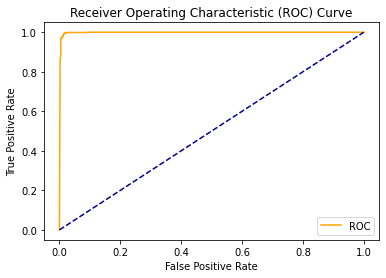

In [35]:
plot_roc_cur(fpr, tpr)

### Roc_curve кривую, матрицу ошибок и отчет по метрикам можно вывести вот такой единой красочной таблицей:

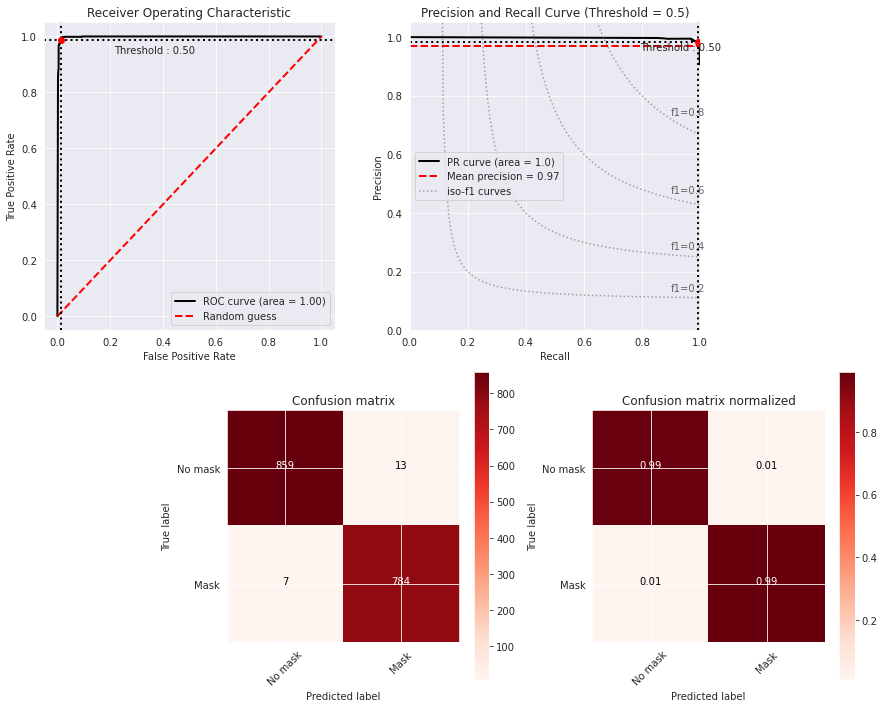

In [36]:
# Визуализируем plot_metric
bc = BinaryClassification(y_test,y_pred_proba, ["No mask","Mask"]) 
# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
#plt.subplot2grid((2,6), (0,4), colspan=2)
#bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)
plt.show()
#bc.print_report()

## Сохраним модель в файл:

In [37]:
model.save('model_mask.hdf5')

### Выведем примеры предсказаний применительно к картинкам  test датасета: 
### 1.Выборка: правильно предсказанные случаи

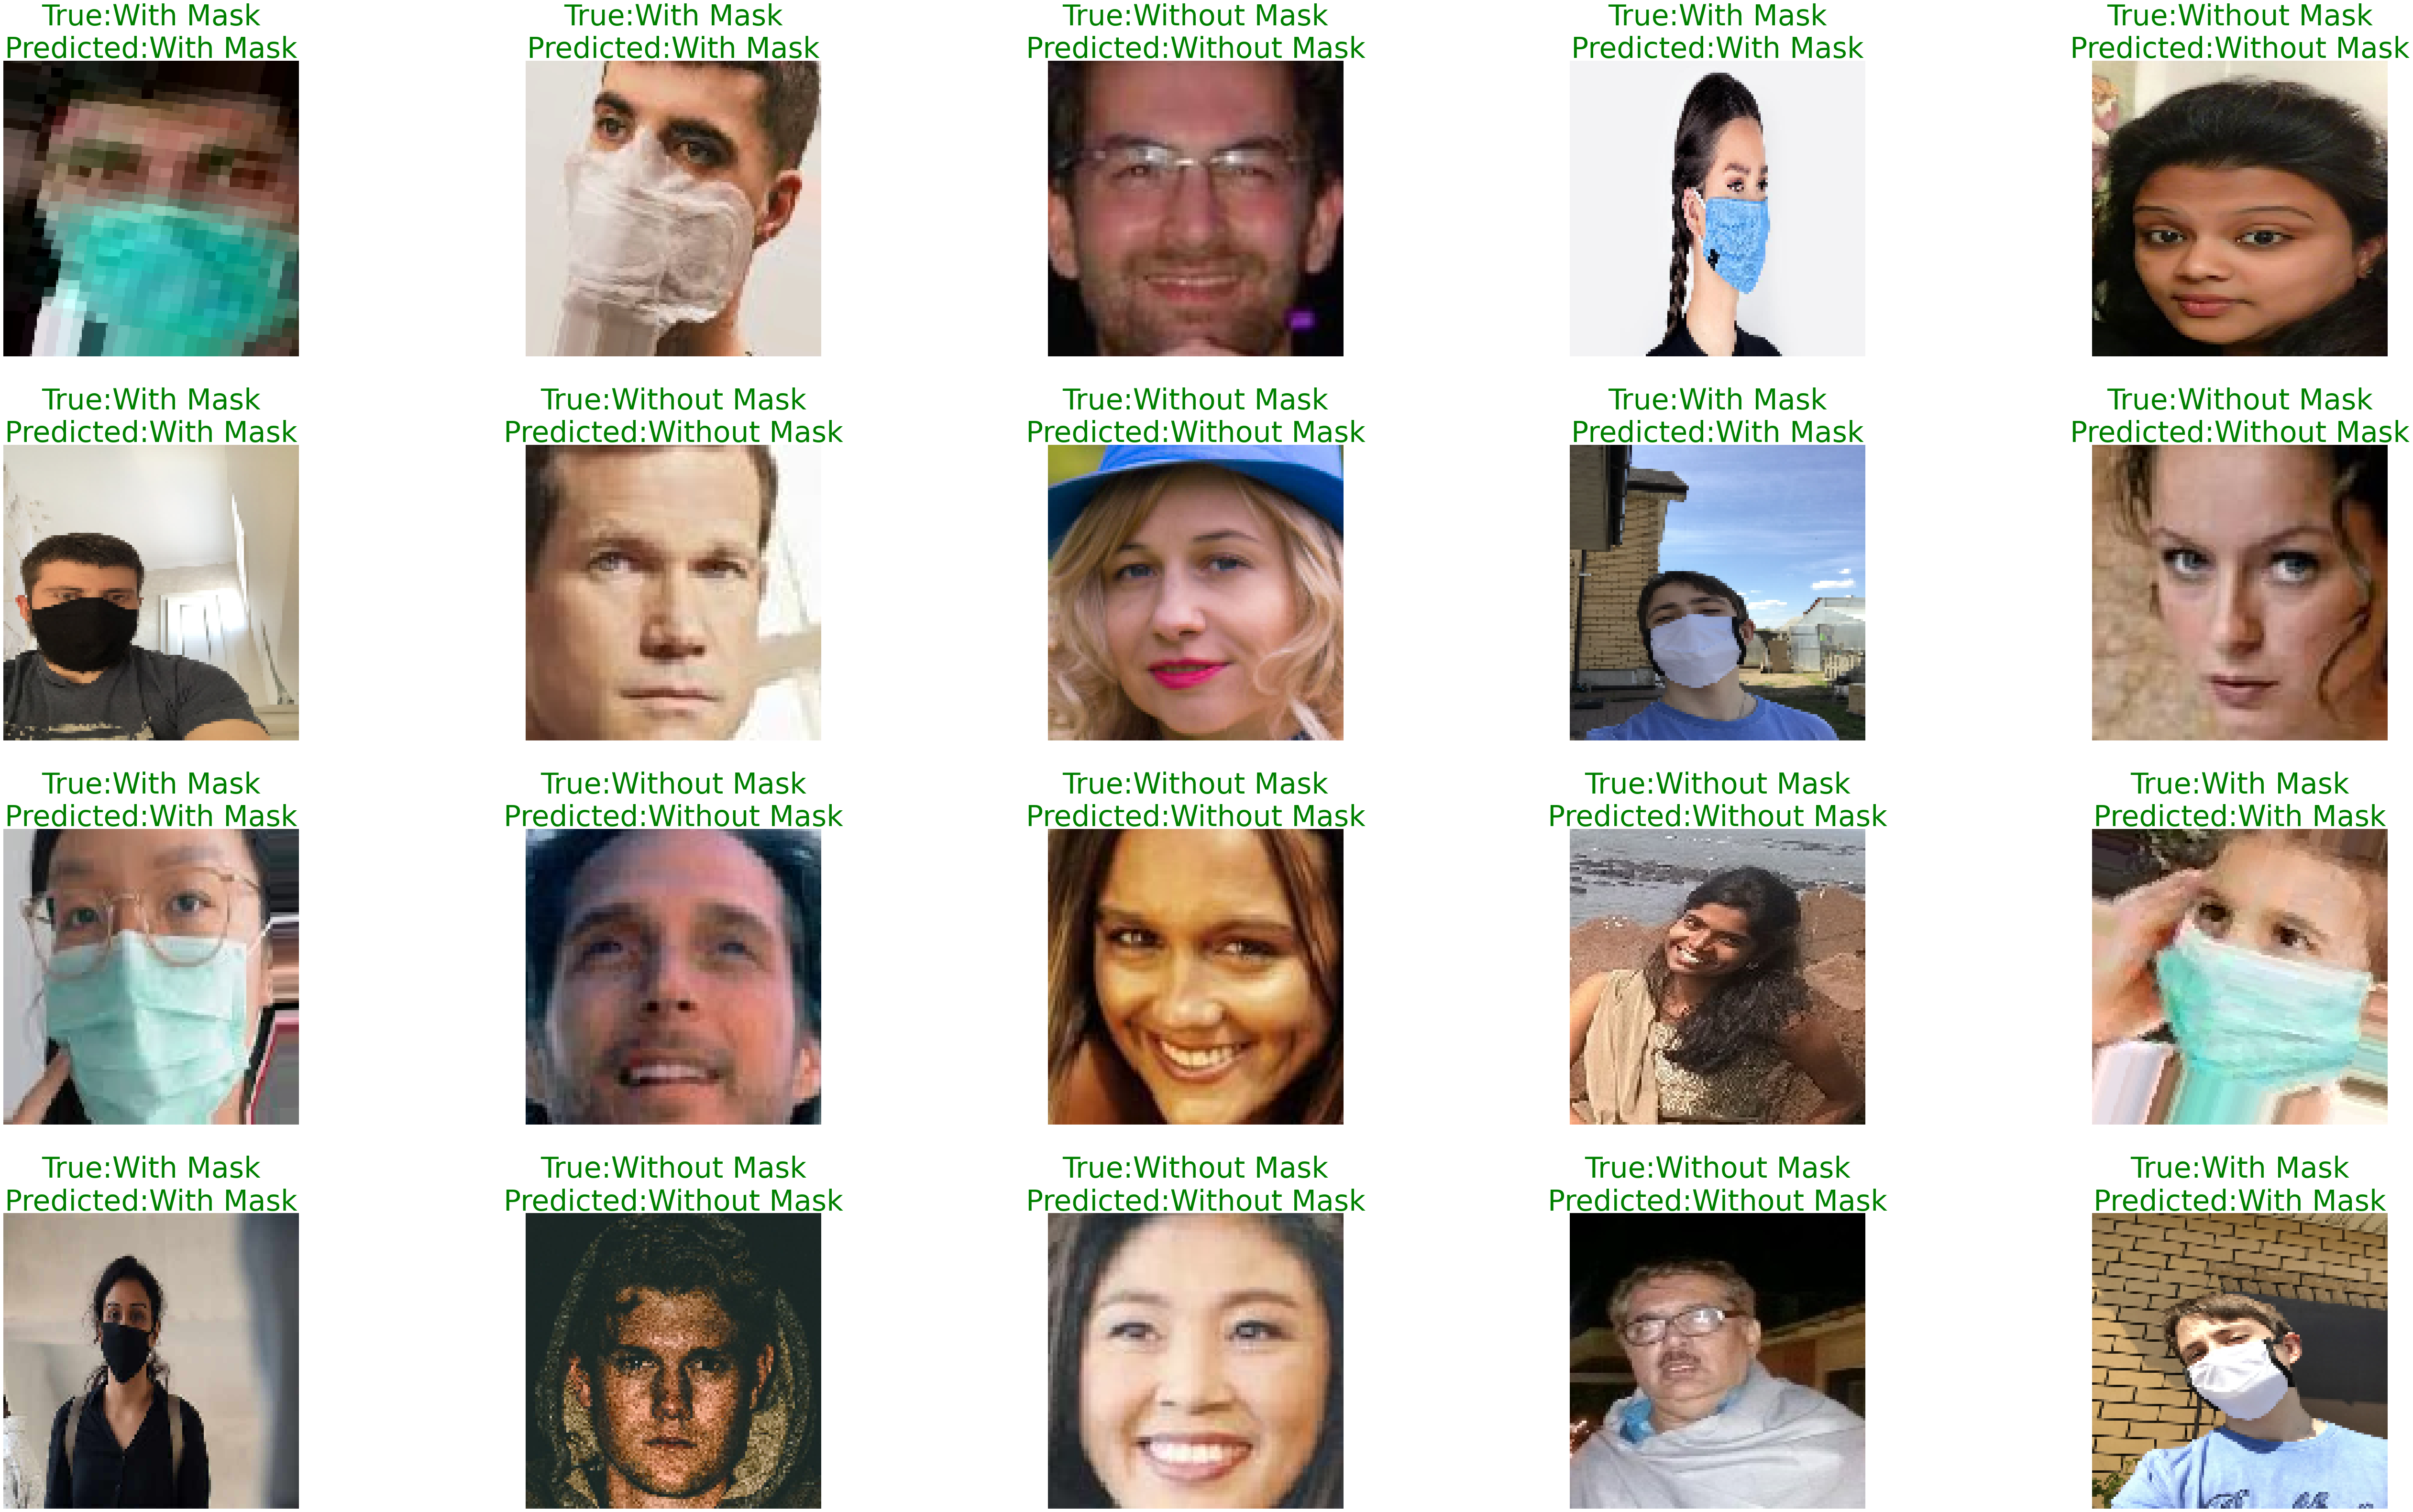

In [38]:
plt.figure(figsize=(100,100))
tempc = np.random.choice(x_test[y_test == y_pred_classes.ravel()].shape[0],20,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_test[y_test == y_pred_classes.ravel()].shape[0])
    plt.imshow(x_test[y_test == y_pred_classes.ravel()][tempc])
    plt.title(f"True:{withWithoutMask[str(y_test[y_test == y_pred_classes.ravel()][tempc])]}\nPredicted:{withWithoutMask[str(y_pred_classes.ravel()[y_test == y_pred_classes.ravel()][tempc])]}",
              fontsize=60,color='g')
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()

### 2.Выборка: неправильно предсказаные случаи.

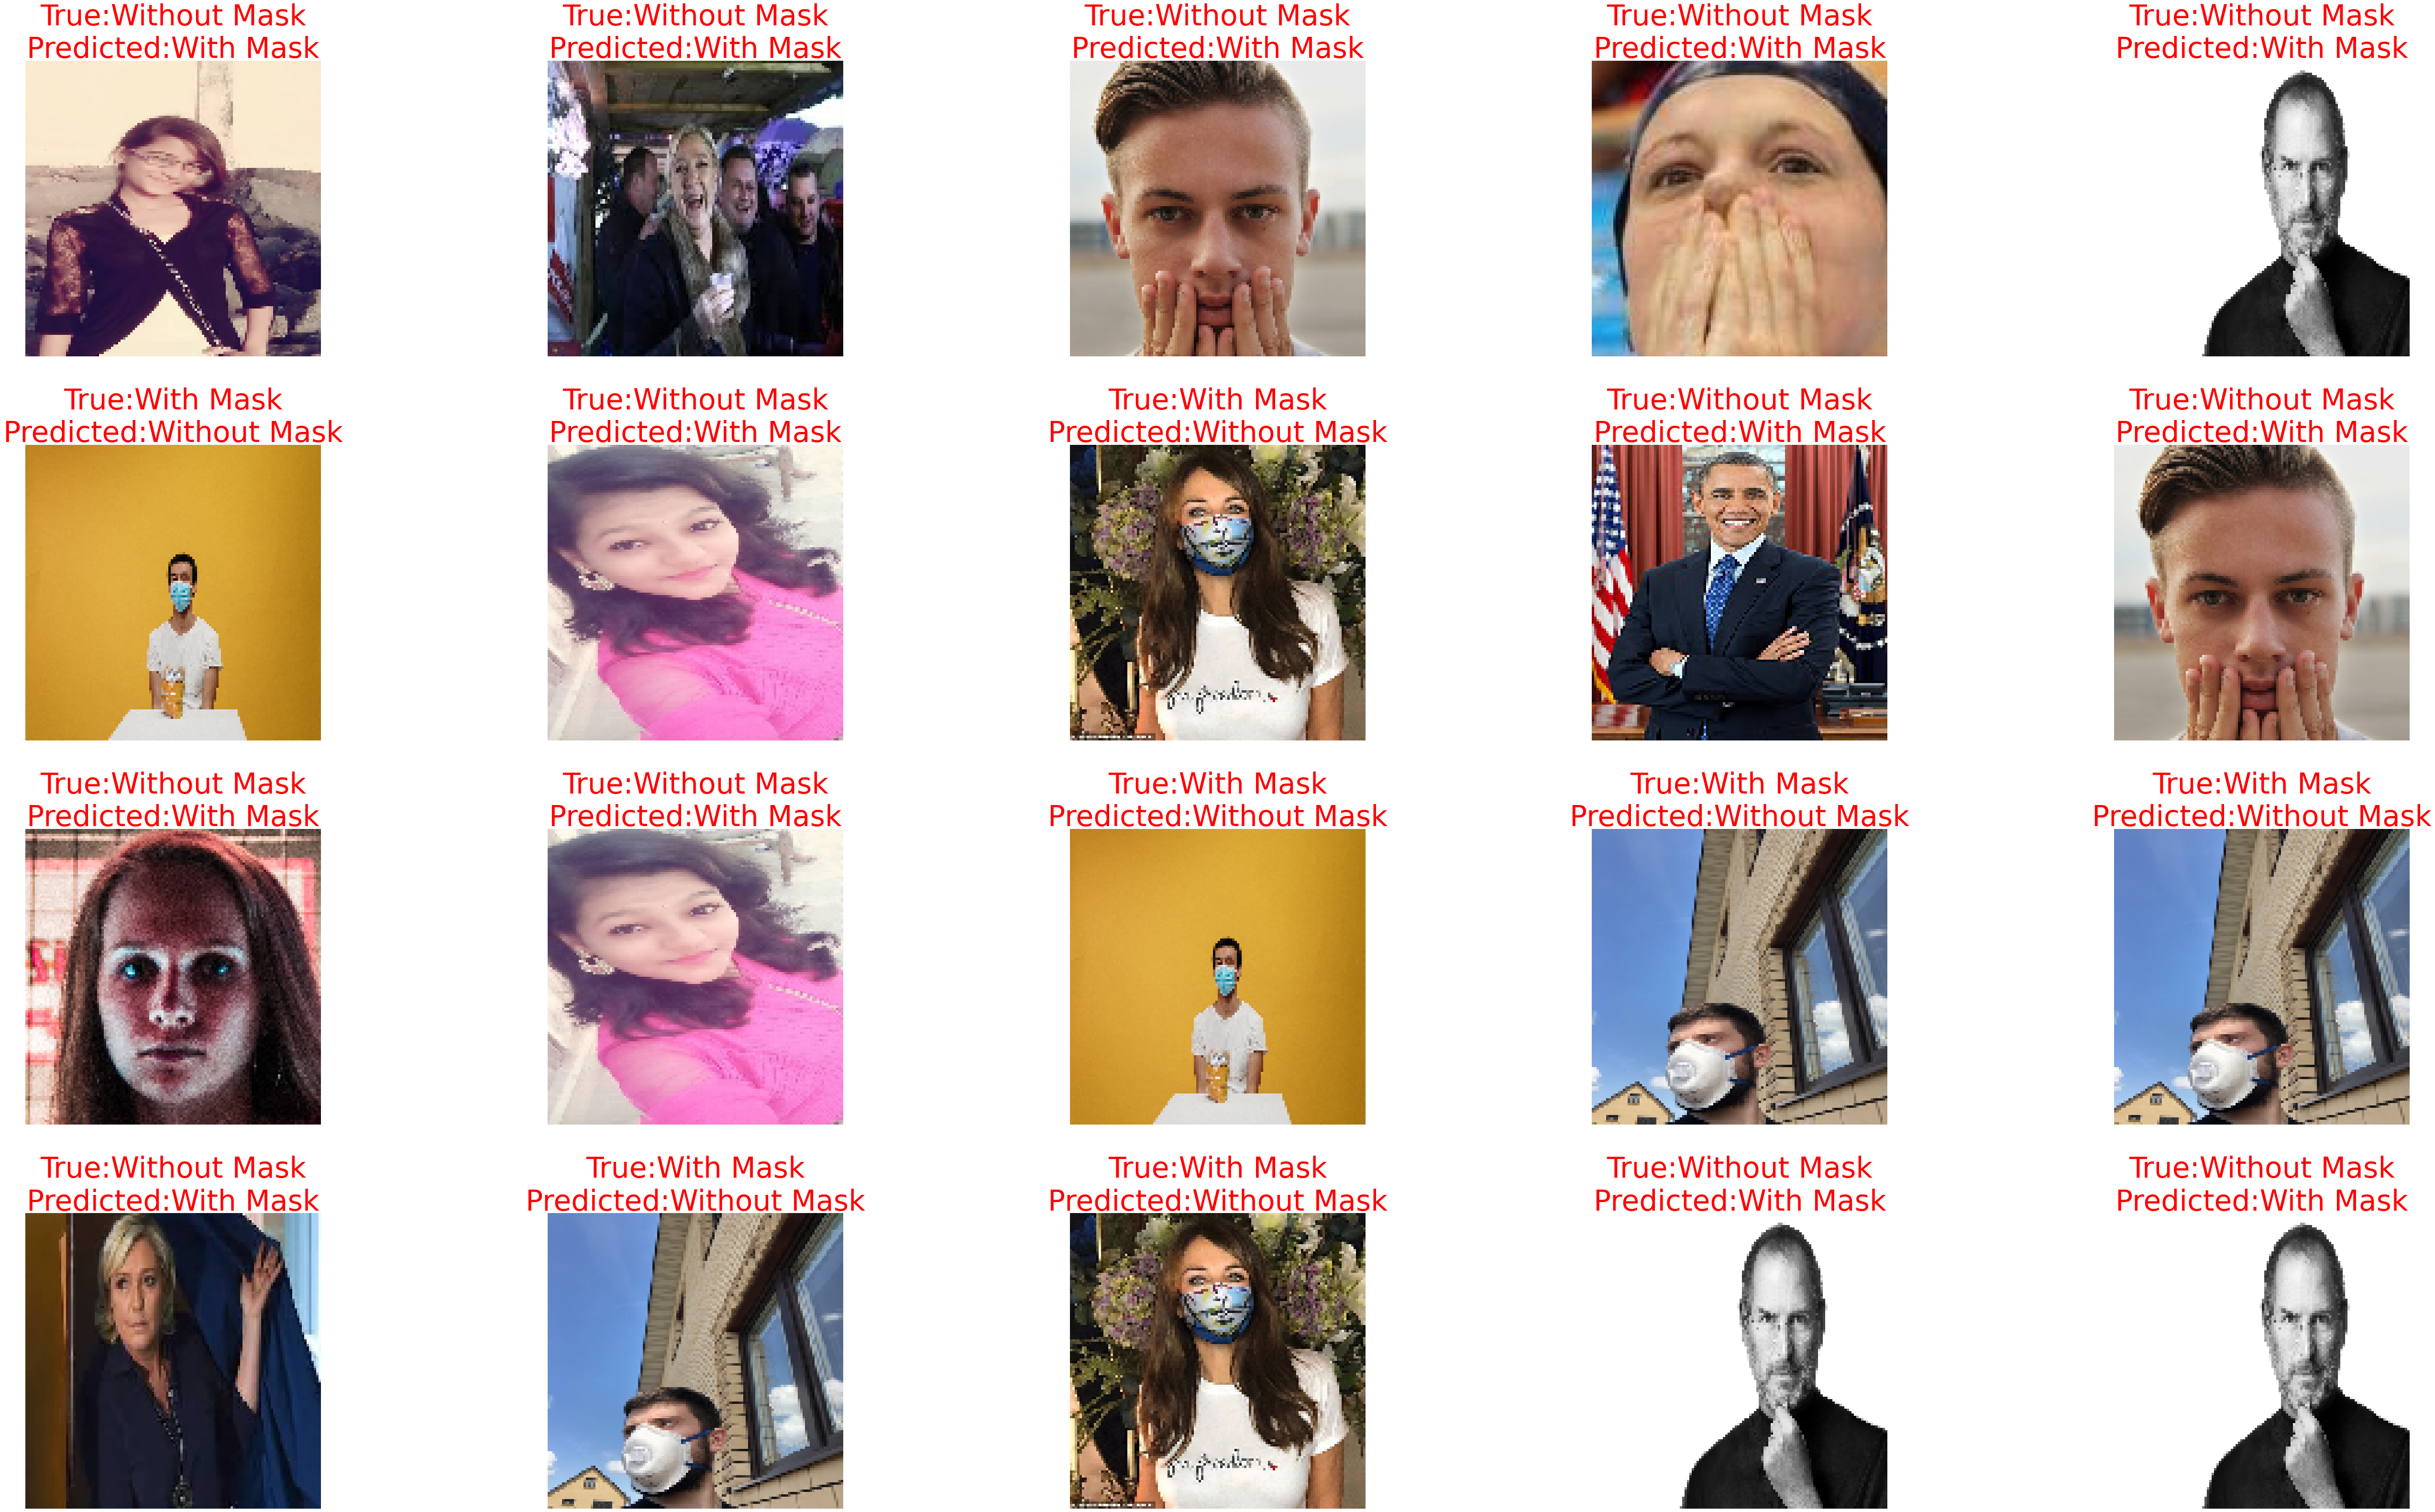

In [39]:
plt.figure(figsize=(100,100))
tempc = np.random.choice(x_test[y_test != y_pred_classes.ravel()].shape[0],20,replace=False)
d = 0
for i in tempc:
    plt.subplot(7, 5, d+1)
    d += 1
    tempc = np.random.randint(x_test[y_test != y_pred_classes.ravel()].shape[0])
    plt.imshow(x_test[y_test != y_pred_classes.ravel()][tempc])
    plt.title(f"True:{withWithoutMask [str(y_test[y_test != y_pred_classes.ravel()][tempc])]}\nPredicted:{withWithoutMask[str(y_pred_classes.ravel()[y_test != y_pred_classes.ravel()][tempc])]}", fontsize=60, color='r')
    plt.axis("off")
plt.subplots_adjust(wspace=-0.1, hspace=0.3)
plt.show()

## Итоги: 
### В данном ноутбуке мы сделали следующее: мы разработали модели согласно поставленной задаче, а именно, сверточную модель на основе нейронных сетей,и модель на базе предобученной нейросети MobilNetV2 large (которая показала лучший результат). Наша модель предсказывает отношения лица к одному из 2 классов ("С Маской"/"Без маски"). Обучили модель. Также мы проанализировали показатели модели. Сохранили модель для дальнейшего использования, сделали сериализацию. Учитывая все сказанное (исходя из полученных показателей), модель должна работать очень хорошо.



### В Vol.2 ноутбуке мы займемся практическим использованием нашей обученной модели для фото, в Vol.3 - мы реализуем максимальные возможности нашей модели на видеопотоке, создадим прототип дальнейшего использования в виде системы контроля Video real-time.